# animating dimension reduction of spike times as point processes
Tim Tyree<br>
2.20.2021

In [23]:
#automate the boring stuff
from lib.getterdone import *

In [24]:
# from lib import *

In [42]:
#search_for_filename
# input_file_name=search_for_file()
#manual data has an ugly dtype
# input_file_name='/Users/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/SRT_CollabData/SortedData_Manual/catTempPopStorage_full.mat'
#early autogen data
input_file_name='/Users/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/SRT_CollabData/SortedData_AutoGen/Archie_SRT_Set226_subset1_201020_142509_UnitStorage.mat'

In [45]:
# import scipy.io as sio
# mat_contents = sio.loadmat(input_file_name)
# sorted(mat_contents.keys())

In [82]:
# #TODO: import mike's .mat file
import h5py
field_lst=['chanNum', 'featSpace', 'spikeInds', 'spikeTimes', 'trialFR', 'trialPSTH', 'trialSpks', 'wvfrms']
with h5py.File(input_file_name, 'r') as f:
#     print(f.keys())
#     print(mat:=f['SRTunitStorage'].keys())#.fletcher32)#.items())#__dir__())
    print(obj:=f['SRTunitStorage']['spikeTimes'])
    #     mat=f['categoricalPopStorage']
    #     print(mat.__dir__())#.keys())
#     print(mat.popitem['chunks'])
    str1 = ''.join(chr(i) for i in obj)
    print( str1 )


<HDF5 dataset "spikeTimes": shape (195, 1), type "|O">


TypeError: only integer scalar arrays can be converted to a scalar index

In [83]:
mat.

SyntaxError: invalid syntax (<ipython-input-83-bcdfa369c6ec>, line 1)

In [84]:
# #represent spiketime trial as a point process in terms of an l x m x n numpy array


In [85]:
#TODO: naïve eigenvalue decomposition of ^that

import mat73
data_dict = mat73.loadmat(input_file_name)

In [20]:
# !pip install mat73
# !pip install hdf5storage


  Using cached hdf5storage-0.1.15-py2.py3-none-any.whl (56 kB)


In [22]:
#TODO: animate a umap with the number of neighbors \propto time
import hdf5storage
mat = hdf5storage.loadmat(input_file_name)


In [95]:
#(doesn't work)generate example data
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')
for i in range(nx):
    for j in range(ny):
        # treat xv[i,j], yv[i,j]
        xv[i,j]=i; yv[i,j]=j
data=np.multiply(xv,yv)

In [108]:
#load example data
from sklearn.datasets import load_digits
digits = load_digits()
data = digits.data
data.shape

(1797, 64)

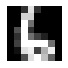

In [137]:
#TODO: Represent point process of spike times as an 8x8 bit image (under some reasonable normalization that is consistent accross samples)
index=212
plt.subplots(figsize=(1,1))
plt.imshow(data[index].reshape((8,8)),cmap='gray')
plt.axis('off')
plt.show()

In [128]:
# Ignore UserWarnings
import warnings
warnings.simplefilter('ignore', UserWarning)
from umap import UMAP

In [129]:
def tween(e1, e2, n_frames=20):
    for i in range(5):
        yield e1
    for i in range(n_frames):
        alpha = i / float(n_frames - 1)
        yield (1 - alpha) * e1 + alpha * e2
    for i in range(5):
        yield(e2)
    return

In [130]:
def generate_frame_data(data, arg_name='n_neighbors', arg_list=[]):
    result = []
    es = []
    for arg in arg_list:
        kwargs = {arg_name:arg}
        if len(es) > 0:
            es.append(UMAP(init=es[-1], negative_sample_rate=3, **kwargs).fit_transform(data))
        else:
            es.append(UMAP(negative_sample_rate=3, **kwargs).fit_transform(data))
        
    for e1, e2 in zip(es[:-1], es[1:]):
        result.extend(list(tween(e1, e2)))
        
    return result

In [131]:
def create_animation(frame_data, arg_name='n_neighbors', arg_list=[]):
    fig, ax = plt.subplots()
    all_data = np.vstack(frame_data)
    frame_bounds = (all_data[:, 0].min() * 1.1, 
                    all_data[:, 0].max() * 1.1,
                    all_data[:, 1].min() * 1.1, 
                    all_data[:, 1].max() * 1.1)
    ax.set_xlim(frame_bounds[0], frame_bounds[1])
    ax.set_ylim(frame_bounds[2], frame_bounds[3])
    points = ax.scatter(frame_data[0][:, 0], frame_data[0][:, 1], 
                        s=5, c=digits.target, cmap='Spectral', animated=True)
    title = ax.set_title('', fontsize=24)
    ax.set_xticks([])
    ax.set_yticks([])

    cbar = fig.colorbar(
        points,
        cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05),
        orientation="vertical",
        values=np.arange(10),
        boundaries=np.arange(11)-0.5,
        ticks=np.arange(10),
        drawedges=True,
    )
    cbar.ax.yaxis.set_ticklabels(np.arange(10), fontsize=18)

    def init():
        points.set_offsets(frame_data[0])
        arg = arg_list[0]
        arg_str = f'{arg:.3f}' if isinstance(arg, float) else f'{arg}'
        title.set_text(f'{arg_name}={arg_str}')
#         title.set_text(f'UMAP with {arg_name}={arg_str}')
        return (points,)

    def animate(i):
        points.set_offsets(frame_data[i])
        if (i + 15) % 30 == 0:
            arg = arg_list[(i + 15) // 30]
            arg_str = f'{arg:.3f}' if isinstance(arg, float) else f'{arg}'
            title.set_text(f'{arg_name}={arg_str}')
#             title.set_text(f'UMAP with {arg_name}={arg_str}')
        return (points,)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_data), interval=20, blit=True)
    plt.close()
    return anim

In [132]:
def animate_param(data, arg_name='n_neighbors', arg_list=[]):
    frame_data = generate_frame_data(data, arg_name, arg_list)
    return create_animation(frame_data, arg_name, arg_list)

In [134]:
# animate_param(data, 'n_neighbors', [3, 4, 5, 7, 10, 15, 25, 50, 100, 200])
# animate_param(data, 'min_dist', [0.0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.9])
animate_param(data, 'local_connectivity', [0.1, 0.2, 0.5, 1, 2, 5, 10])
# animate_param(data, 'set_op_mix_ratio', np.linspace(0.0, 1.0, 10))

In [104]:
assert (not np.isnan(data).any())
print (np.max(data))

2.0


In [ ]:
%%time
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

#embed interactive video toys in your documents!  
# http://localhost:8888/notebooks/umap/notebooks/Document%20embedding%20using%20UMAP.ipynb

- I would expect the Mahalanobis distance to be the natural measure of gaussian distributions embedded in $\mathbb{R}^{+64}$.
- Hellinger distance measures the distance between two probability distributions
- Consider XX[i] as the true distribution of times since each neuron has fired conditioned on the ith neuron having just fired? 
    - Question: what is the hellinger distance between the distributions __before vs. after__ the stimulus onset at time t=0?  
    - Question: what is the hellinger distance between the max liklihood estimate for XX[i] and the uniform distribution UU[i] (as a null hypothesis?)


In [136]:
#for a discussion of the following distance measures, see
# http://localhost:8888/notebooks/umap/notebooks/UMAP%20usage%20and%20parameters.ipynb

### ``metric``

The final UMAP parameter we will be considering in this notebook is the ``metric`` parameter. This controls how distance is computed in the ambient space of the input data. By default UMAP supports a wide variety of metrics, including:

**Minkowski style metrics**
* euclidean
* manhattan
* chebyshev
* minkowski

**Miscellaneous spatial metrics**
* canberra
* braycurtis
* haversine

**Normalized spatial metrics**
* mahalanobis
* wminkowski
* seuclidean

**Angular and correlation metrics**
* cosine
* correlation

**Metrics for binary data**
* hamming
* jaccard
* dice
* russelrao
* kulsinski
* rogerstanimoto
* sokalmichener
* sokalsneath
* yule

Any of which can be specified by setting ``metric='<metric name>'``; for example to use cosine distance as the metric you would use ``metric='cosine'``.

UMAP offers more than this however -- it supports custom user defined metrics as long as those metrics can be compiled in ``nopython`` mode by numba. For this notebook we will be looking at such custom metrics. To define such metrics we'll need numba ...

# TODO: apply naïve umap to a point process representation of one trial.
- TODO: look for a convenient interface to explore .mat files or .hdf5 files.  MATLAB?  Then, how to import to python?  Save to .hdf5 file?

- TODO: import 1 trial of spiketimes as a numpy array
    - N = number of neurons
- TODO: for the i^th neuron, compute the time since last firing for each neuron, X[i]
    - X[i][j,k] = the latest time since the k^th neuron has fired at the time the j^th time the i^th neuron has fired
- TODO: compute at least one interesting UMAP .mp4 for each neuron, i=1,...,N


and then,
- TODO: find two trials that are a match/mismatch pair, 

In [135]:
pip install hdf5plugin

     |████████████████████████████████| 829 kB 3.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
